<a href="https://colab.research.google.com/github/BrajanNieto/MPPT_Algorithms/blob/main/IA_Fundamentals_Evaluation_MPPT_Algorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**IA Fundamentals - MPPT Algorithms**

---



*   This script focuses on evaluating the efficiency of Maximum Power Point Tracking (MPPT) algorithms in photovoltaic (solar) systems. It conducts a comparative analysis of three specific algorithms: Perturb and Observe (P&O), Genetic Algorithms (GA), and Artificial Neural Networks (ANN).

**Professor:**  
Mg. Machaca Vicente Arceda  
[vicente.machaca.a@gmail.com](mailto:vicente.machaca.a@gmail.com)

**Authors:**  
Nevado Talledo, Jose E.  
[jose.nevado@utec.edu.pe](mailto:jose.nevado@utec.edu.pe)

Nieto Espinoza, Brajan E.  
[brajan.nieto@utec.edu.pe](mailto:brajan.nieto@utec.edu.pe)

Peña la Torre, Walter J.

[walter.pena.l@utec.edu.pe](mailto:walter.pena.l@utec.edu.pe)


<img src="https://pregrado.utec.edu.pe/sites/default/files/logo-utec-h_0_0.svg" width="190" alt="Logo UTEC" loading="lazy" typeof="foaf:Image">

---

In [1]:
# Import standard libraries for numerical computations and data handling
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.special import lambertw
import math
from tqdm import tqdm
from sklearn.neural_network import MLPRegressor

# **1 Problem and Fitness Formulation**
In this section, the theoretical behavior of a **single-diode solar panel** is modeled. The following components are addressed:

1. **Definition of Profiles**:
   - **Temperature profile**: Variation of panel temperature over time.
   - **Irradiance profile**: Variation of solar irradiance over time.

2. **Modeling the Theoretical Behavior**:
   - Using the single-diode model equations to describe the relationship between current, voltage, and power under different conditions.

3. **Maximum Power Behavior**:
   - The calculation and visualization of the **maximum power output** (\(P_{max}\)) as a function of time, based on the temperature and irradiance profiles.

### Objective:
This formulation lays the foundation for analyzing the performance of the solar panel in dynamic environmental conditions, providing insights into its efficiency and energy output over time.


## 1.1 Irradiance and Temperature Profile
Defines functions that models the variation of irradiance and temperature over time in a photovoltaic system. The function uses conditional statements to describe changes in irradiance based on specified time intervals.

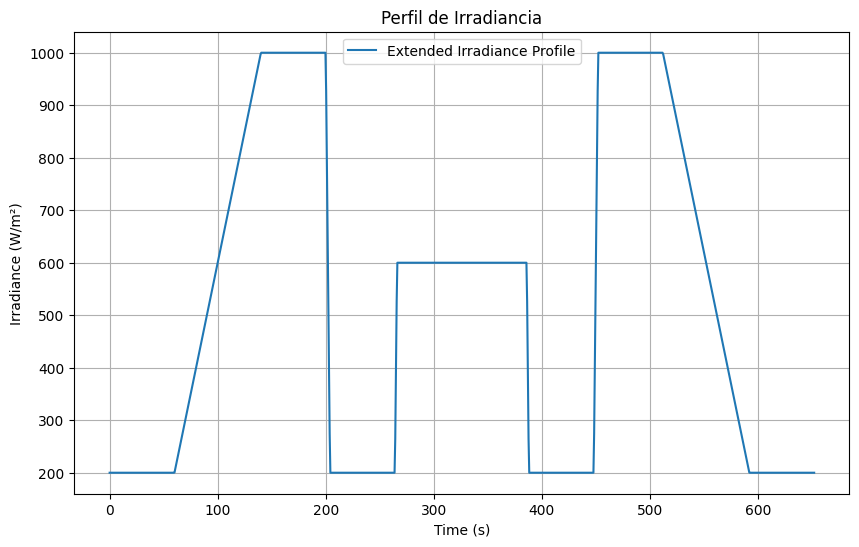

In [2]:
def irradiance_profile(time):
    """
    Defines how irradiance varies over time.
    """
    if time <= 60:
        return 200
    elif 60 < time <= 140:
        return 200 + 10 * (time - 60)
    elif 140 < time <= 200:
        return 1000
    elif 200 < time <= 204:
        return 1000 - 200 * (time - 200)
    elif 204 < time <= 264:
        return 200
    elif 264 < time <= 266:
        return 200 + 200 * (time - 264)
    elif 266 < time <= 386:
        return 600
    elif 386 < time <= 388:
        return 600 - 200 * (time - 386)
    elif 388 < time <= 448:
        return 200
    elif 448 < time <= 452:
        return 200 + 200* (time - 448)
    elif 452 < time <= 512:
        return 1000
    elif 512 < time <= 592:
        return 1000 - 10 * (time - 512)
    elif 592 < time <= 652:
        return 200
    else:
        return 200


time_extended = np.linspace(0, 652, 1000)
irradiance_extended = [irradiance_profile(t) for t in time_extended]

# Plot the extended irradiance profile
plt.figure(figsize=(10, 6))
plt.plot(time_extended, irradiance_extended, label="Extended Irradiance Profile")
plt.title("Perfil de Irradiancia")
plt.xlabel("Time (s)")
plt.ylabel("Irradiance (W/m²)")
plt.grid()
plt.legend()
plt.show()


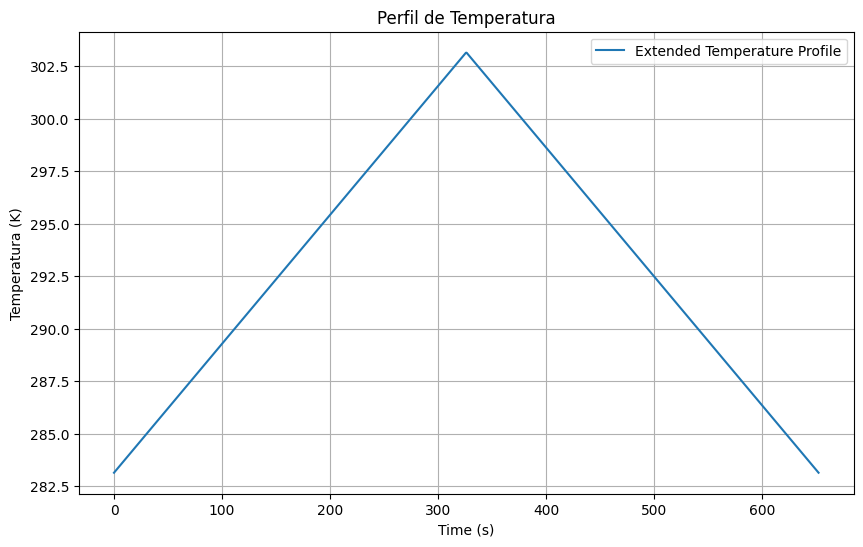

In [3]:
def temperature_profile(time):
    """
    Defines how temperature varies over time.
    """
    if time <= 326:
        # Temperature increases from 25°C (298.15 K) to 35°C (308.15 K) over 326 seconds
        return 283.15 + (time / 326) * 20
    elif 326 < time <= 652:
        # Temperature decreases from 35°C (308.15 K) to 25°C (298.15 K) over 326 seconds
        return 303.15 - ((time - 326) / 326) * 20
    else:
        return 298.15


temperature_extended = [temperature_profile(t) for t in time_extended]

# Plot the temperature profile over time.
plt.figure(figsize=(10, 6))
plt.plot(time_extended, temperature_extended, label="Extended Temperature Profile")
plt.title("Perfil de Temperatura")
plt.xlabel("Time (s)")
plt.ylabel("Temperatura (K)")
plt.grid()
plt.legend()
plt.show()


## 1.2 Photocurrent (Iph)

Calculate_Iph function to compute the photocurrent (Iph) as a function of time, temperature, and irradiance. The calculation uses temperature and irradiance profiles, alongside key reference parameters. The script then plots the time-dependent behavior of Iph.

The equation used to calculate the photocurrent \(I_{ph}\) is:

$I_{ph} = \left(I_{sc\_ref} + \alpha_{Isc} \cdot (T - T_{ref})\right) \cdot \frac{G}{G_{ref}}$

Where:

- $I_{sc\_ref}$: Short-circuit current under standard conditions (A).
- $\alpha_{Isc}$: Temperature coefficient for $I_{sc}$ (in A/K).
- $T$: Temperature in Kelvin as a function of time.
- $T_{ref}$: Reference temperature in Kelvin.
- $G$: Solar irradiance (in W/m²) as a function of time.
- $G_{ref}$: Reference solar irradiance (in W/m²).


In [4]:
# Solar panel parameters
I_sc_ref = 8.5        # Short-circuit current under standard conditions (A)
alpha_Isc = 0.0005    # Temperature coefficient of I_sc (A/K)
T_ref = 298.15        # Reference temperature (25°C in Kelvin)
G_ref = 1000          # Reference solar irradiance (W/m²)

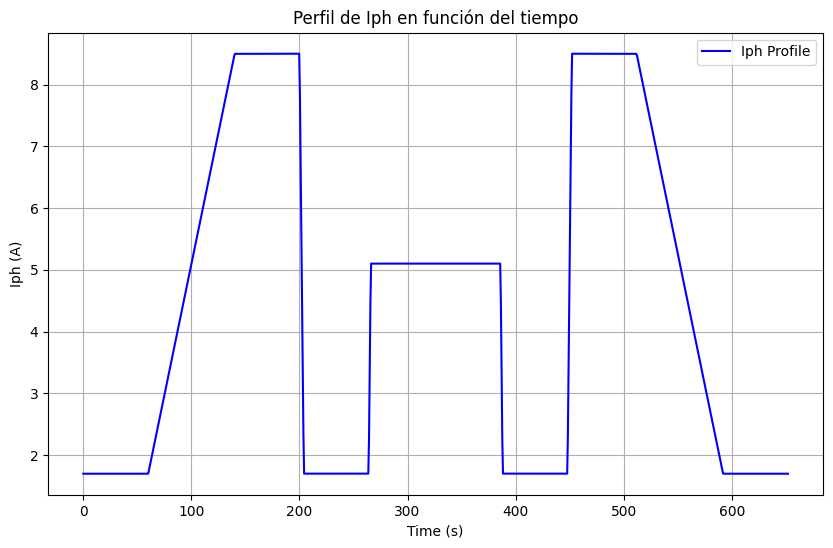

In [5]:
def calculate_Iph(time, I_sc_ref, alpha_Isc, T_ref, G_ref):
    """
    Calculates the photocurrent (Iph) as a function of time.

    Parameters:
        time (float): Time at which Iph is calculated.
        I_sc_ref (float): Short-circuit current under standard conditions (A).
        alpha_Isc (float): Temperature coefficient of Isc (A/K).
        T_ref (float): Reference temperature in Kelvin.
        G_ref (float): Reference solar irradiance (W/m^2).

    Returns:
        float: Value of Iph at the given time.
    """
    # Get temperature (T) and irradiance (G) values from their respective profiles
    T = temperature_profile(time)  # Temperature in Kelvin
    G = irradiance_profile(time)   # Irradiance in W/m^2

    # Calculate Iph using the formula:
    Iph = (I_sc_ref + alpha_Isc * (T - T_ref)) * (G / G_ref)
    return Iph


Iph_extended = [calculate_Iph(t, I_sc_ref, alpha_Isc, T_ref, G_ref) for t in time_extended]

# Plot the Iph profile
plt.figure(figsize=(10, 6))
plt.plot(time_extended, Iph_extended, label="Iph Profile", color='blue')
plt.title("Perfil de Iph en función del tiempo")
plt.xlabel("Time (s)")
plt.ylabel("Iph (A)")
plt.grid()
plt.legend()
plt.show()

## 1.3 Reverse Saturation Current ($ I_0 $)

La corriente de saturación inversa del diodo, $ I_0 $, se calcula con la siguiente fórmula:

$
I_0 = I_{sc\_ref} \cdot \left( \frac{T}{T_{ref}} \right)^3 \cdot e^{-\frac{E_g \cdot q}{k \cdot T}}
$

Where:

- $I_{sc_{ref\_cell}}$: Short-circuit current per cell under reference conditions.
- $V_{oc_{ref\_cell}}$: Open-circuit voltage per cell under reference conditions.
- $n$: Ideality factor.
- $T_{ref}$: Reference temperature (K).
- $T$: Temperature as a function of time (K).
- $E_{g}$: Energy bandgap of the semiconductor (eV).
- $k$: Boltzmann constant (\(1.38 \times 10^{-23} \, \text{J/K}\)).
- $q$: Electron charge (\(1.6 \times 10^{-19} \, \text{C}\)).
- $I_0$: Reverse saturation current at a given time.


In [6]:
# Physical constants
k = 1.380649e-23     # Boltzmann constant (J/K)
q = 1.602176634e-19  # Electron charge (C)

# Solar panel parameters
V_oc_ref = 22.0       # Open-circuit voltage under standard conditions (V)
n = 1.3               # Diode ideality factor
E_g = 1.1             # Bandgap energy (eV)
R_s = 0.1             # Series resistance (Ω)
R_sh = 1000.0         # Shunt resistance (Ω)

# Determine the number of cells in series
V_oc_cell = 0.611        # Open-circuit voltage per cell (V)
N_s = int(V_oc_ref / V_oc_cell)  # Number of cells in series
#print(f"Number of cells in series: {N_s}")

# Parameters per cell
I_sc_ref_cell = I_sc_ref            # Short-circuit current per cell (A)
V_oc_ref_cell = V_oc_ref / N_s      # Open-circuit voltage per cell (V)
R_s_cell = R_s / N_s                # Series resistance per cell (Ω)
R_sh_cell = R_sh * N_s              # Shunt resistance per cell (Ω)

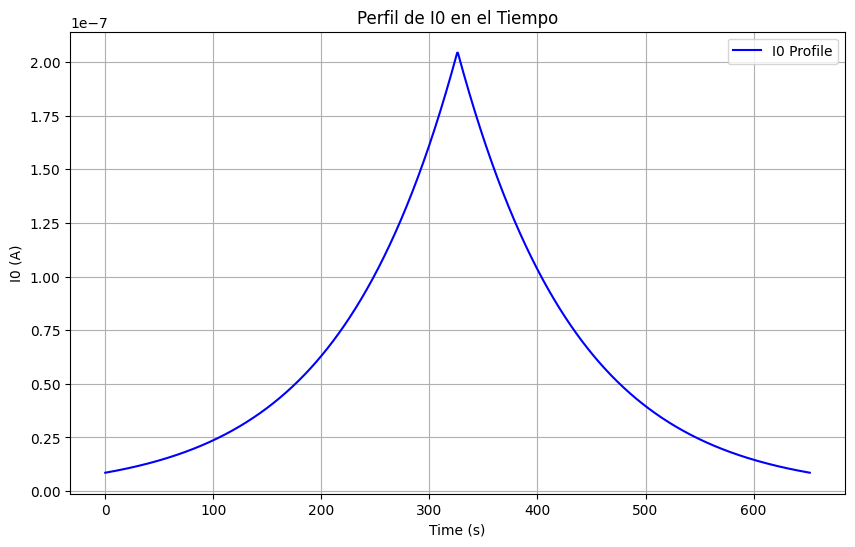

In [7]:
def calculate_I0(time, I_sc_ref_cell, V_oc_ref_cell, n, T_ref, E_g, k, q):
    """
    Calculates the reverse saturation current (I0) of a solar cell as a function of time.

    Parameters:
    - time: Current time (in seconds).
    - I_sc_ref_cell: Short-circuit current per cell under reference conditions (A).
    - V_oc_ref_cell: Open-circuit voltage per cell under reference conditions (V).
    - n: Diode ideality factor.
    - T_ref: Reference temperature (K).
    - E_g: Bandgap energy (eV).
    - k: Boltzmann constant (J/K).
    - q: Electron charge (C).

    Returns:
    - I0: Reverse saturation current at the given time (A).
    """
    T = temperature_profile(time)  # Temperature at the given time (K)
    E_g_J = E_g * q                # Bandgap energy in Joules
    V_t_ref = k * T_ref / q        # Thermal voltage under reference conditions (V)
    exponent_ref = q * V_oc_ref_cell / (n * k * T_ref)  # Exponent for reference conditions

    # Calculate I0_ref, the reverse saturation current under reference conditions
    if exponent_ref > 100:
        I0_ref = I_sc_ref_cell * math.exp(-exponent_ref)
    else:
        I0_ref = I_sc_ref_cell / (math.exp(exponent_ref) - 1)

    # Temperature-dependent terms
    delta_T_inv = (1 / T) - (1 / T_ref)  # Inverse temperature difference
    exponent = -E_g_J / k * delta_T_inv  # Temperature exponent

    # Calculate I0 as a function of time
    I0 = I0_ref * (T / T_ref)**3 * math.exp(exponent)
    return I0

# Plot the I0 profile over time
I0_extended = [calculate_I0(t, I_sc_ref_cell, V_oc_ref_cell, n, T_ref, E_g, k, q) for t in time_extended]
plt.figure(figsize=(10, 6))
plt.plot(time_extended, I0_extended, label="I0 Profile", color='blue')
plt.title("Perfil de I0 en el Tiempo")
plt.xlabel("Time (s)")
plt.ylabel("I0 (A)")
plt.grid()
plt.legend()


##1.4 Single-Diode model


The single-diode model for a solar panel is described by the following equation:

$I = I_{ph} - I_0 \cdot \left( e^{\frac{q \cdot (V + I \cdot R_s)}{n \cdot k \cdot T}} - 1 \right) - \frac{V + I \cdot R_s}{R_{sh}}$

### Donde:
- $I$: Output current of the solar panel (A).
- $I_{ph}$: Photocurrent generated by the incident light (A).
- $I_0$: Reverse saturation current of the diode (A).
- $q$: Electron charge (\(1.602 \times 10^{-19} \, C\)).
- $V$: Voltage across the terminals of the solar panel (V).
- $R_s$: Series resistance of the solar panel (\(\Omega\)).
- $R_{sh}$: Parallel (shunt) resistance of the solar panel (\(\Omega\)).
- $n$: Ideality factor of the diode (typically between 1 and 2).
- $k$: Boltzmann constant (\(1.381 \times 10^{-23} \, J/K\)).
- $T$: Absolute temperature of the panel (K).

In [8]:
def current_single_diode(V, time, I_sc_ref, alpha_Isc, V_oc_ref, n, T_ref, G_ref, E_g, R_s, R_sh, k, q):
    """
    Calculates the current of a single-diode solar cell model given the voltage and time.

    Parameters:
    - V: Voltage across the solar cell (V).
    - time: Current time (in seconds).
    - I_sc_ref: Reference short-circuit current under standard conditions (A).
    - alpha_Isc: Temperature coefficient of the short-circuit current (A/K).
    - V_oc_ref: Reference open-circuit voltage (V).
    - n: Diode ideality factor.
    - T_ref: Reference temperature (K).
    - G_ref: Reference solar irradiance (W/m²).
    - E_g: Bandgap energy (eV).
    - R_s: Series resistance (Ω).
    - R_sh: Shunt resistance (Ω).
    - k: Boltzmann constant (J/K).
    - q: Electron charge (C).

    Returns:
    - Current (I) through the solar cell (A).
    """
    # Calculate the photo-generated current (I_ph)
    I_ph = calculate_Iph(time, I_sc_ref, alpha_Isc, T_ref, G_ref)
    # Calculate the reverse saturation current (I_0)
    I_0 = calculate_I0(time, I_sc_ref, V_oc_ref, n, T_ref, E_g, k, q)
    # Get the temperature at the given time
    T = temperature_profile(time)
    # Calculate the thermal voltage
    V_t = k * T / q

    # Define the implicit diode equation to solve
    def diode_equation(I):
        exponent = (V + I * R_s) / (n * V_t)
        # Control the exponent to avoid OverflowError
        if exponent > 700:
            exp_term = np.exp(700)  # Limit the exponential term to prevent overflow
        else:
            exp_term = np.exp(exponent)
        return I_ph - I_0 * (exp_term - 1) - (V + I * R_s) / R_sh - I

    # Use fsolve to solve the diode equation
    I_initial_guess = I_ph  # Initial guess for the solution
    I_solution, info, ier, mesg = fsolve(diode_equation, I_initial_guess, full_output=True)
    # Check if the solver converged
    if ier != 1:
        # print(f"Solution not found for V={V}, time={time}: {mesg}")
        I_solution = [np.nan]  # Assign NaN if the solution does not converge
    return I_solution[0]


## 1.5 Calculation of IV and PV Profiles for Different Times

This section focuses on the calculation of the **IV (current-voltage)** and **PV (power-voltage)** profiles for a solar panel at different time intervals. These profiles aid in the **visual inspection** of the panel's performance under varying conditions.

### Key Objectives:
1. Compute the **IV profile**: Relationship between current (\(I\)) and voltage (\(V\)).
2. Compute the **PV profile**: Relationship between power (\(P\)) and voltage (\(V\)).
3. Enable visual analysis of how environmental factors, such as temperature and irradiance, affect the panel's performance.

### Visual Inspection:
- The **IV curve** provides insight into the maximum current and voltage the panel can deliver.
- The **PV curve** highlights the maximum power point (MPP), where the panel operates most efficiently.

Graphs generated from these profiles allow for the assessment of:
- The **impact of changing environmental conditions** over time.
- The **efficiency and performance** of the solar panel in real-time scenarios.

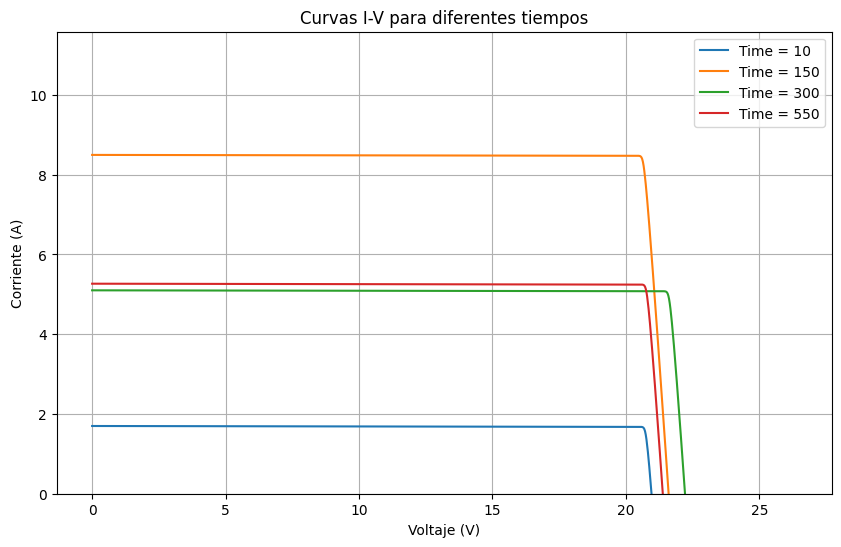

In [9]:
# Specific times
times = [10, 150, 300, 550]  # You can adjust these values

# Voltage range
V_values = np.linspace(0, V_oc_ref * 1.2, 1000)  # 1000 points between 0 V and 1.2 * V_oc_ref

# Plot the I-V curves for each specified time
plt.figure(figsize=(10, 6))
for time in times:
    I_values = []  # List to store current values
    for V in V_values:
        # Calculate the current using the single-diode model
        I = current_single_diode(V, time, I_sc_ref, alpha_Isc, V_oc_ref, n,
                                 T_ref, G_ref, E_g, R_s, R_sh, k, q)
        I_values.append(I)
    # Plot the I-V curve for the current time
    plt.plot(V_values, I_values, label=f'Time = {time}')

# Limit the Y-axis to non-negative values
plt.ylim(0, None)

# Customize labels and legend
plt.title('Curvas I-V para diferentes tiempos')
plt.xlabel('Voltaje (V)')
plt.ylabel('Corriente (A)')
plt.legend()
plt.grid(True)
plt.show()

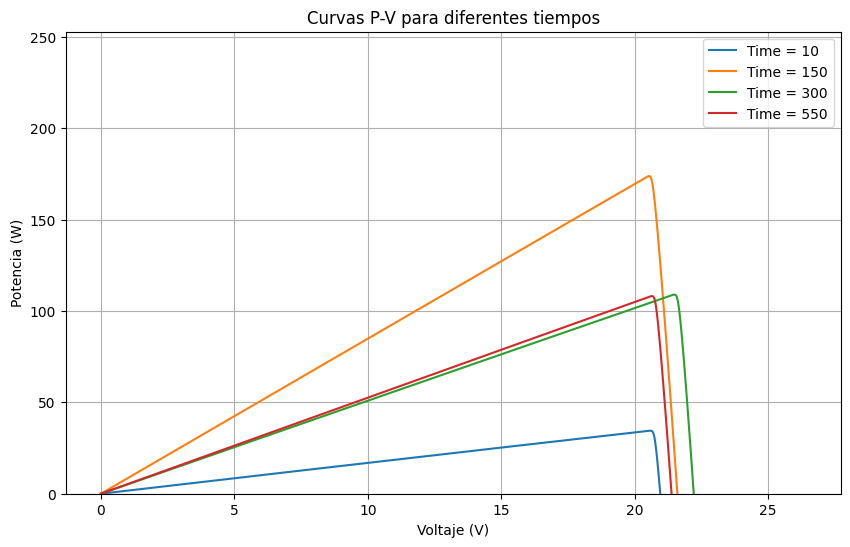

In [10]:
# Specific times
times = [10, 150, 300, 550]  # You can adjust these values

# Voltage range
V_values = np.linspace(0, V_oc_ref * 1.2, 1000)  # 1000 points between 0 V and 1.2 * V_oc_ref

# Plot the P-V curves for each specified time
plt.figure(figsize=(10, 6))
for time in times:
    P_values = []  # List to store power values
    for V in V_values:
        # Calculate the current using the single-diode model
        I = current_single_diode(V, time, I_sc_ref, alpha_Isc, V_oc_ref, n,
                                 T_ref, G_ref, E_g, R_s, R_sh, k, q)
        P = V * I  # Calculate power as the product of voltage and current
        P_values.append(P)
    # Plot the P-V curve for the current time
    plt.plot(V_values, P_values, label=f'Time = {time}')

# Limit the Y-axis to non-negative values
plt.ylim(0, None)

# Customize labels and legend
plt.title('Curvas P-V para diferentes tiempos')
plt.xlabel('Voltaje (V)')
plt.ylabel('Potencia (W)')
plt.legend()
plt.grid(True)
plt.show()

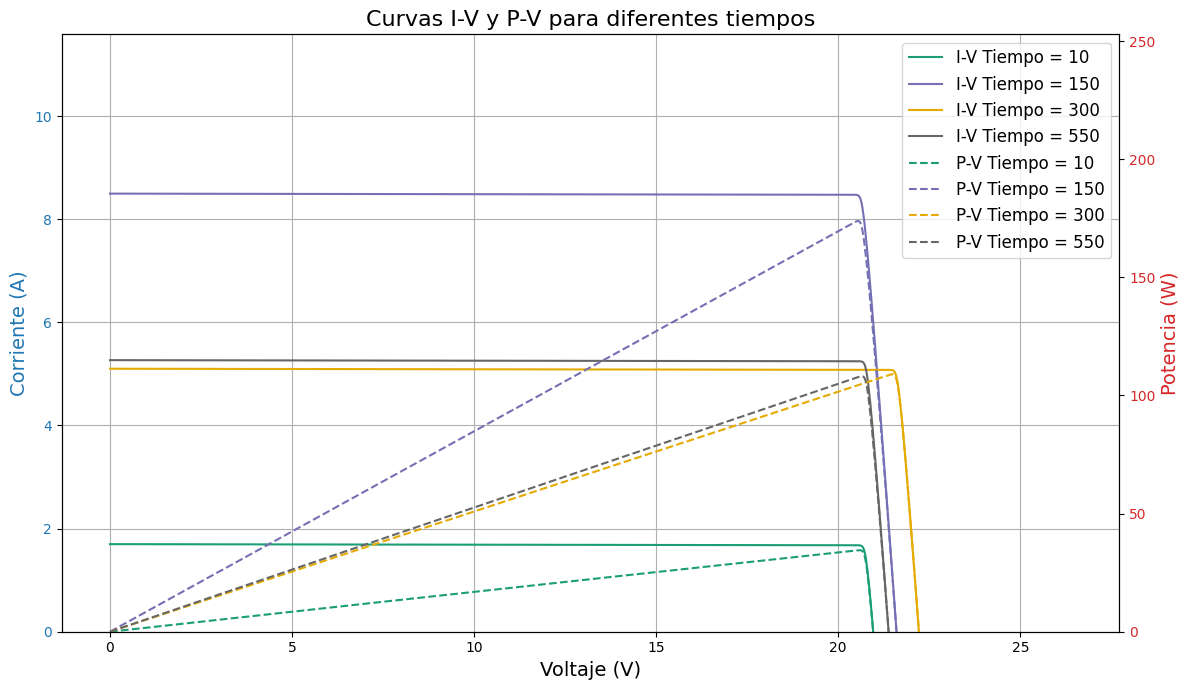

In [11]:
# Specific times
times = [10, 150, 300, 550]  # You can adjust these values

# Voltage range
V_values = np.linspace(0, V_oc_ref * 1.2, 1000)  # 1000 points between 0 V and 1.2 * V_oc_ref

# Create the figure and main axis
fig, ax1 = plt.subplots(figsize=(12, 7))

# Colors for different times
colors = plt.cm.Dark2(np.linspace(0, 1, len(times)))

# Plot the I-V curves for each time on the main axis
for idx, time in enumerate(times):
    I_values = []  # List to store current values
    for V in V_values:
        # Calculate the current using the single-diode model
        I = current_single_diode(V, time, I_sc_ref, alpha_Isc, V_oc_ref, n,
                                T_ref, G_ref, E_g, R_s, R_sh, k, q)
        I_values.append(I)
    ax1.plot(V_values, I_values, label=f'I-V Tiempo = {time}', color=colors[idx], linestyle='-')

# Configure the primary Y-axis (Current)
ax1.set_xlabel('Voltaje (V)', fontsize=14)
ax1.set_ylabel('Corriente (A)', fontsize=14, color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_ylim(0, None)  # Limit to non-negative values

# Create the secondary Y-axis for Power
ax2 = ax1.twinx()

# Plot the P-V curves for each time on the secondary axis
for idx, time in enumerate(times):
    P_values = []  # List to store power values
    for V in V_values:
        # Calculate power as the product of voltage and current
        I = current_single_diode(V, time, I_sc_ref, alpha_Isc, V_oc_ref, n,
                                T_ref, G_ref, E_g, R_s, R_sh, k, q)
        P = V * I
        P_values.append(P)
    ax2.plot(V_values, P_values, label=f'P-V Tiempo = {time}', color=colors[idx], linestyle='--')

# Configure the secondary Y-axis (Power)
ax2.set_ylabel('Potencia (W)', fontsize=14, color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.set_ylim(0, None)  # Limit to non-negative values

# Title and legends
plt.title('Curvas I-V y P-V para diferentes tiempos', fontsize=16)

# Manage legends for both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=12)

# Add a grid
ax1.grid(True)

# Display the plot
plt.tight_layout()
plt.show()


## 1.6 Calculation of Maximum Power as a Function of Time

Given the functions that model the theoretical IV curve based on the solar panel parameters, along with the irradiance and temperature profiles over time, this section focuses on calculating the **maximum power curve** as a function of time.

### Key Steps:
1. Utilize the theoretical IV curve equations to compute power (\(P = V \cdot I\)) for varying voltage and current values.
2. Incorporate time-dependent profiles of:
   - **Irradiance** (t).
   - **Temperature** (t).
3. Identify the **Maximum Power Point (MPP)** at each time interval, where the panel operates with maximum efficiency.

In [12]:
# Time range (in seconds)
time_start = 1  # Start time
time_end = 650  # End time
time_steps = np.arange(time_start, time_end + 0.1)  # Include time_end in the range


Processing times: 100%|██████████| 650/650 [00:19<00:00, 33.70it/s]


   Time (s)   Pmax (W)
0       1.0  34.419236
1       2.0  34.423234
2       3.0  34.426758
3       4.0  34.429868
4       5.0  34.432614


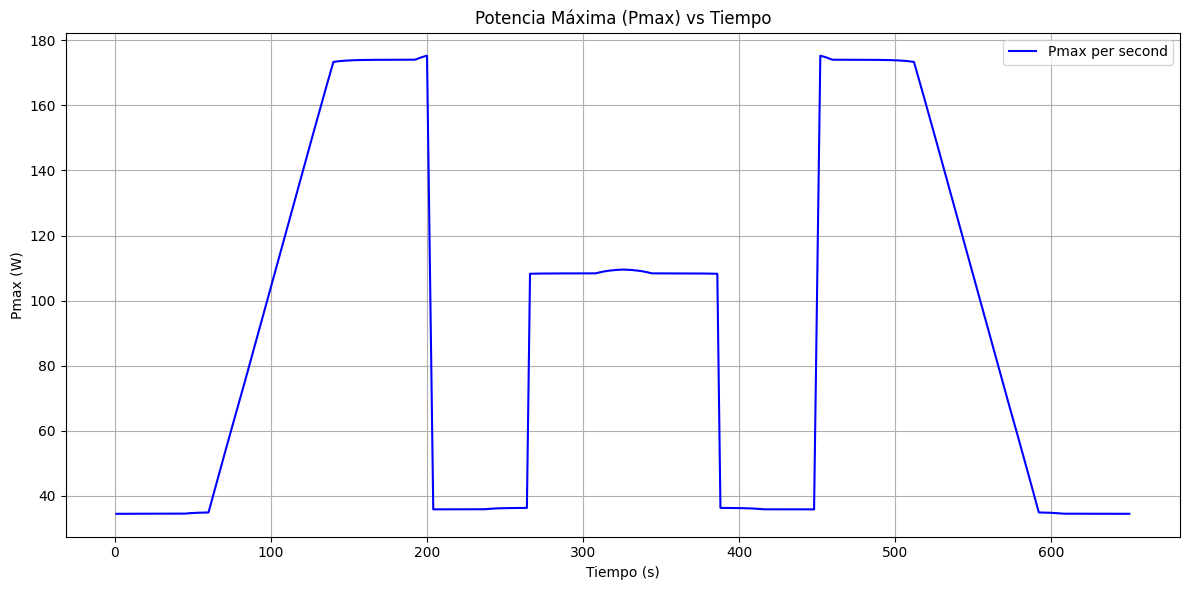

In [13]:
# List to store Pmax and corresponding times
pmax_list = []
time_list = []

# Maximum voltage multiplier for each time
V_max_multiplier = 1.2  # Multiplier for V_oc_ref

# Number of voltage points (adjust for required precision)
V_points = 100

# Iterate over each second in the time range
for current_time in tqdm(time_steps, desc="Processing times"):
    # Define the voltage range for the current time
    V_oc_current = V_oc_ref  # Assuming V_oc_ref is constant; adjust if variable
    V_max = V_max_multiplier * V_oc_current
    V_range = np.linspace(0, V_max, V_points)

    # Lists to store V, I, and P for the current time
    I_values = []
    P_values = []

    # Iterate over each voltage
    for V in V_range:
        # Calculate current using the single-diode model
        I = current_single_diode(V, current_time, I_sc_ref, alpha_Isc, V_oc_ref, n, T_ref, G_ref, E_g, R_s, R_sh, k, q)
        if np.isnan(I):
            P = 0  # Assign 0 power if the current was not found
        else:
            P = V * I  # Calculate power as the product of voltage and current
        I_values.append(I)
        P_values.append(P)

    # Find Pmax and its corresponding index
    P_values = np.array(P_values)
    if np.all(np.isnan(P_values)):
        P_max = np.nan
    else:
        P_max = np.nanmax(P_values)  # Use np.nanmax to ignore NaNs

    # Store the results
    pmax_list.append(P_max)
    time_list.append(current_time)

# Create a DataFrame with the results
df_pmax = pd.DataFrame({
    'Time (s)': time_list,
    'Pmax (W)': pmax_list
})

# Display the first few rows of the DataFrame
print(df_pmax.head())

# Save the results to a CSV file (optional)
# df_pmax.to_csv('pmax_vs_time.csv', index=False)

# Plot Pmax vs Time
plt.figure(figsize=(12, 6))
plt.plot(df_pmax['Time (s)'], df_pmax['Pmax (W)'], color='blue', label='Pmax per second')
plt.title('Potencia Máxima (Pmax) vs Tiempo')
plt.xlabel('Tiempo (s)')
plt.ylabel('Pmax (W)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

     Time (s)   Pmax (W)  Irradiance  Irradiance/Pmax Ratio
0         1.0  34.419236       200.0               5.810704
1         2.0  34.423234       200.0               5.810029
2         3.0  34.426758       200.0               5.809435
3         4.0  34.429868       200.0               5.808910
4         5.0  34.432614       200.0               5.808447
..        ...        ...         ...                    ...
645     646.0  34.435039       200.0               5.808038
646     647.0  34.432614       200.0               5.808447
647     648.0  34.429868       200.0               5.808910
648     649.0  34.426758       200.0               5.809435
649     650.0  34.423234       200.0               5.810029

[650 rows x 4 columns]


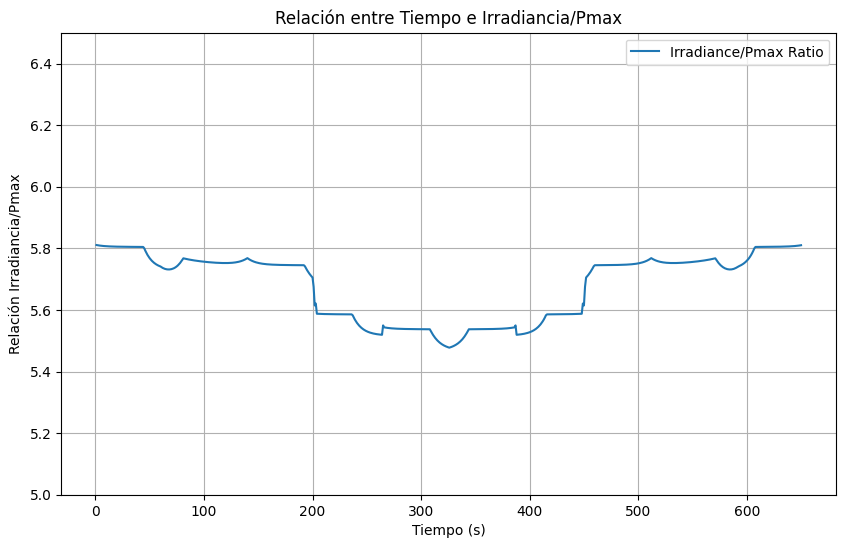

In [14]:
# Add a column for irradiance using the function
df_pmax['Irradiance'] = df_pmax['Time (s)'].apply(irradiance_profile)

# Add a column for the ratio between irradiance and Pmax
df_pmax['Irradiance/Pmax Ratio'] = df_pmax['Irradiance'] / df_pmax['Pmax (W)']

# Display the resulting DataFrame
print(df_pmax)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(df_pmax['Time (s)'], df_pmax['Irradiance/Pmax Ratio'], linestyle='-', label='Irradiance/Pmax Ratio')
plt.title('Relación entre Tiempo e Irradiancia/Pmax')
plt.xlabel('Tiempo (s)')
plt.ylabel('Relación Irradiancia/Pmax')
plt.ylim(5, 6.5)  # Scale the Y-axis between 5 and 7
plt.grid()
plt.legend()
plt.show()

# **2. Algorithms Implementation  P&O, GA and ANN**

In this section, algorithms for **Maximum Power Point Tracking (MPPT)** are developed based on the behavior of the solar panel modeled in the previous section. The implementation focuses on three approaches:

### Algorithms:
1. **Classic P&O (Perturb and Observe)**:
   - A widely used, traditional algorithm for MPPT.
   - Iteratively perturbs the operating point and observes the power output to adjust towards the maximum power point.

2. **Genetic Algorithm (GA)**:
   - An optimization algorithm inspired by natural selection.
   - Searches for the maximum power point by evolving a population of candidate solutions.

3. **Neural Network MPPT**:
   - A machine learning approach using a **Multi-Layer Perceptron (MLP) regressor**.
   - Trains the neural network to predict the maximum power point based on the input conditions (e.g., temperature and irradiance).

### Objective:
These algorithms aim to evaluate and compare different strategies for achieving MPPT under dynamic environmental conditions, highlighting their efficiency and adaptability.



## 02.1 P&O and IC Algorithms

In this section, the two classical algorithms, **Perturb and Observe (P&O)** and **Incremental Conductance (IC)**, are implemented to determine the next operating voltage ($V_{\text{next}}$) based on previous results, starting from an initial point ($V_0$).

### Description of Algorithms:
1. **Perturb and Observe (P&O)**:
   - Perturbs the voltage ($V$) and observes the change in power ($P$).
   - Adjusts the operating point based on whether the power increases or decreases:
     - If $P$ increases, the perturbation is continued in the same direction.
     - If $P$ decreases, the perturbation direction is reversed.

2. **Incremental Conductance (IC)**:
   - Compares the incremental conductance ($dI/dV$) to the instantaneous conductance ($-I/V$):
     - When $dI/dV = -I/V$, the maximum power point (MPP) is reached.
     - Adjusts the operating voltage ($V_{\text{next}}$) accordingly.

In [15]:
def incremental_conductance(V_prev, I_prev, dV, dI):
    """
    Implements the incremental conductance algorithm.

    Parameters:
        V_prev (float): Voltage at the previous step.
        I_prev (float): Current at the previous step.
        dV (float): Voltage change (V_current - V_previous).
        dI (float): Current change (I_current - I_previous).

    Returns:
        V_next (float): Adjusted voltage for the next step.
    """
    if dV == 0:
        return V_prev  # Avoid division by zero

    G_inc = dI / dV  # Incremental conductance
    G_inst = I_prev / V_prev  # Instantaneous conductance

    if abs(G_inc + G_inst) < 1e-6:
        # Maximum power point reached
        V_next = V_prev
    elif G_inc + G_inst > 0:
        # Increase voltage
        V_next = V_prev + delta_V
    else:
        # Decrease voltage
        V_next = V_prev - delta_V

    return V_next

In [16]:
def perturb_and_observe(V_prev, P_prev, delta_V, direction):
    """
    Implements the perturb and observe (P&O) algorithm.

    Parameters:
        V_prev (float): Voltage at the previous step.
        P_prev (float): Power at the previous step.
        delta_V (float): Voltage perturbation step.
        direction (int): Current direction (1 to increase, -1 to decrease).

    Returns:
        V_next (float): Adjusted voltage for the next step.
        direction (int): Updated direction.
    """
    # Calculate the next voltage based on the current direction
    V_next = V_prev + direction * delta_V
    return V_next, direction



## 02.2 Genetic Algorithm (GA)

In this section, a **Genetic Algorithm (GA)** is implemented to perform Maximum Power Point Tracking (MPPT). The algorithm operates through steps like :
1. **Population Generation**
2. **Fitness Evaluation**
3. **Selection**
4. **Crossover and Mutation**
5. **Replacement**
6. **Iteration**

In [17]:
def genetic_algorithm(time, V_min, V_max, population_size, generations):
    """
    Implements a simplified version of a genetic algorithm to find the optimal voltage.

    Parameters:
        time (float): Current time.
        V_min (float): Minimum possible voltage.
        V_max (float): Maximum possible voltage.
        population_size (int): Size of the population.
        generations (int): Number of generations.

    Returns:
        V_best (float): Optimal voltage found.
    """
    # Generate initial population
    population = np.random.uniform(V_min, V_max, population_size)

    for _ in range(generations):
        # Evaluate fitness
        fitness = []
        for V in population:
            # Calculate current using the single-diode model
            I = current_single_diode(V, time, I_sc_ref, alpha_Isc, V_oc_ref, n, T_ref, G_ref, E_g, R_s, R_sh, k, q)
            # Calculate power as the product of voltage and current
            P = V * I if not np.isnan(I) else 0
            fitness.append(P)
        fitness = np.array(fitness)

        # Select the best individuals
        indices = np.argsort(fitness)[-population_size // 2:]  # Select the top half
        population = population[indices]

        # Crossover and mutation
        children = []
        while len(children) < population_size:
            # Randomly select two parents
            parents = np.random.choice(population, 2)
            # Create a child by averaging the parents
            child = np.mean(parents)
            # Apply mutation
            mutation_prob_AG = 0.01
            if np.random.rand() < mutation_prob_AG:
                child += np.random.normal(0, (V_max - V_min) * 0.01)
            # Ensure the child remains within valid voltage limits
            child = np.clip(child, V_min, V_max)
            children.append(child)
        population = np.array(children)

    # Best solution
    best_index = np.argmax(fitness)
    V_best = population[best_index]
    return V_best

## 02.3 Neural Networks

In this section, a neural network based on the **Multi-Layer Perceptron (MLP) Regressor** is implemented for Maximum Power Point Tracking (MPPT).

### Key Features:
- **Model**: The MLP regressor is used to predict the operating voltage (\(V_{\text{MPP}}\)) that maximizes the power output (\(P\)).
- **Input Features**:
  - Environmental conditions: temperature (\(T\)) and irradiance (\(G\)).
- **Output**:
  - Predicted optimal voltage (\(V_{\text{MPP}}\)).

In [81]:
def train_neural_network(times, V_oc_ref):
    """
    Trains a neural network to predict the optimal voltage.

    Parameters:
        times (array): Array of times for training.
        V_oc_ref (float): Reference open-circuit voltage.

    Returns:
        model: Trained MLPRegressor model.
    """
    # Training data (using the voltage at which Pmax was achieved)
    V_optimal = []  # List to store optimal voltages
    for time in times:
        # Generate voltage values for the current time
        V_values = np.linspace(0, V_oc_ref * 1.2, 100)
        P_values = []
        for V in V_values:
            # Calculate the current using the single-diode model
            I = current_single_diode(V, time, I_sc_ref, alpha_Isc, V_oc_ref, n, T_ref,
                                     G_ref, E_g, R_s, R_sh, k, q)
            if np.isnan(I):
                P = 0  # Set power to 0 if current is NaN
            else:
                P = V * I  # Calculate power as voltage times current
            P_values.append(P)
        P_values = np.array(P_values)

        # Find the index of the maximum power
        idx_max = np.argmax(P_values)
        # Append the corresponding voltage to V_optimal
        V_optimal.append(V_values[idx_max])

    # Prepare training data
    X_train = np.array(times).reshape(-1, 1)  # Reshape times into a 2D array
    y_train = np.array(V_optimal)  # Optimal voltages as target values

    # Create and train the neural network model
    model = MLPRegressor(hidden_layer_sizes=(10, 10), max_iter=1000)  # Neural network with two hidden layers
    model.fit(X_train, y_train)
    return model


# **3. Experimentation**

This section focuses on conducting four experiments to gather valuable insights from the implemented algorithms and approaches.

### Experiments:

* Experiment 1: Classical Algorithm vs Optimization

* Experiment 2: Classical Algorithm vs Artificial Intelligence
* Experiment 3: Variations in GA Initialization and Selection

* Experiment 4: Implementation of a Different Radiation Profile

### Summary:
The results from these experiments will provide insights into the strengths and weaknesses of each approach, helping to identify the most effective MPPT strategies under diverse scenarios.


In [30]:
# Additional parameters for the algorithms
delta_V = 0.01  # Voltage step for P&O and IC
population_size = 10  # Population size for the genetic algorithm
generations = 5       # Number of generations for the genetic algorithm
V_min = 12
V_max = V_oc_ref * 1.2

# Train the neural network before the main loop
time_steps = np.arange(time_start, time_end + 0.1)
model_nn = train_neural_network(time_steps, V_oc_ref)

# Variables to store the results
results = {
    'Tiempo': [],
    'Pmax': [],
    'P_IC': [],
    'P_PO': [],
    'P_GA': [],
    'P_NN': [],
    'Eficiencia_IC': [],
    'Eficiencia_PO': [],
    'Eficiencia_GA': [],
    'Eficiencia_NN': []
}

# Initialize variables for P&O and IC
V_prev_IC = V_min
V_prev_PO = V_min
I_prev_IC = current_single_diode(V_prev_IC, time_start, I_sc_ref, alpha_Isc, V_oc_ref, n, T_ref, G_ref, E_g, R_s, R_sh, k, q)
I_prev_PO = current_single_diode(V_prev_PO, time_start, I_sc_ref, alpha_Isc, V_oc_ref, n, T_ref, G_ref, E_g, R_s, R_sh, k, q)
P_prev_PO = V_prev_PO * I_prev_PO
direction_PO = 1  # Initial direction for P&O

# Main loop
for current_time in tqdm(time_steps, desc="Processing times"):
    # Update V_max if V_oc changes with time
    V_max_current = V_max  # Adjust this if V_oc varies with time

    # Calculate the real Pmax
    V_values = np.linspace(V_min, V_max_current, 100)
    P_values = []
    for V in V_values:
        I = current_single_diode(V, current_time, I_sc_ref, alpha_Isc, V_oc_ref, n, T_ref, G_ref, E_g, R_s, R_sh, k, q)
        P = V * I if not np.isnan(I) else 0
        P_values.append(P)
    P_values = np.array(P_values)
    idx_max = np.argmax(P_values)
    P_max = P_values[idx_max]
    V_max_power = V_values[idx_max]

    # Incremental Conductance
    I_current_IC = current_single_diode(V_prev_IC, current_time, I_sc_ref, alpha_Isc, V_oc_ref, n, T_ref, G_ref, E_g, R_s, R_sh, k, q)
    dV_IC = delta_V
    dI_IC = I_current_IC - I_prev_IC
    V_next_IC = incremental_conductance(V_prev_IC, I_current_IC, dV_IC, dI_IC)
    I_prev_IC = I_current_IC
    V_prev_IC = V_next_IC
    P_IC = V_next_IC * I_current_IC

    # Perturb and Observe
    V_next_PO, direction_PO = perturb_and_observe(V_prev_PO, P_prev_PO, delta_V, direction_PO)
    I_current_PO = current_single_diode(V_next_PO, current_time, I_sc_ref, alpha_Isc, V_oc_ref, n, T_ref, G_ref, E_g, R_s, R_sh, k, q)
    P_current_PO = V_next_PO * I_current_PO
    if P_current_PO > P_prev_PO:
        # Continue in the same direction
        pass
    else:
        # Change direction
        direction_PO *= -1
    V_prev_PO = V_next_PO
    P_prev_PO = P_current_PO
    P_PO = P_current_PO

    # Genetic Algorithm
    V_GA = genetic_algorithm(current_time, V_min, V_max_current, population_size, generations)
    I_GA = current_single_diode(V_GA, current_time, I_sc_ref, alpha_Isc, V_oc_ref, n, T_ref, G_ref, E_g, R_s, R_sh, k, q)
    P_GA = V_GA * I_GA if not np.isnan(I_GA) else 0

    # Neural Network
    V_NN = model_nn.predict([[current_time]])[0]
    I_NN = current_single_diode(V_NN, current_time, I_sc_ref, alpha_Isc, V_oc_ref, n, T_ref, G_ref, E_g, R_s, R_sh, k, q)
    P_NN = V_NN * I_NN if not np.isnan(I_NN) else 0

    # Store results
    results['Tiempo'].append(current_time)
    results['Pmax'].append(P_max)
    results['P_IC'].append(P_IC)
    results['P_PO'].append(P_PO)
    results['P_GA'].append(P_GA)
    results['P_NN'].append(P_NN)
    results['Eficiencia_IC'].append(P_IC / P_max if P_max != 0 else 0)
    results['Eficiencia_PO'].append(P_PO / P_max if P_max != 0 else 0)
    results['Eficiencia_GA'].append(P_GA / P_max if P_max != 0 else 0)
    results['Eficiencia_NN'].append(P_NN / P_max if P_max != 0 else 0)

# Create a DataFrame with the results
df_results = pd.DataFrame(results)

# Display the first few results
print(df_results.head())


Processing times: 100%|██████████| 650/650 [00:37<00:00, 17.14it/s]

   Tiempo       Pmax       P_IC       P_PO       P_GA       P_NN  \
0     1.0  34.387348  20.252913  20.252793  27.052956  26.213418   
1     2.0  34.404836  20.269730  20.269610  30.575570  27.169126   
2     3.0  34.420259  20.286547  20.286427  33.202510  28.083630   
3     4.0  34.433856  20.303364  20.303244  31.886239  28.953874   
4     5.0  34.445838  20.320181  20.320060  33.974767  29.642840   

   Eficiencia_IC  Eficiencia_PO  Eficiencia_GA  Eficiencia_NN  
0       0.588964       0.588961       0.786713       0.762298  
1       0.589154       0.589150       0.888700       0.789689  
2       0.589378       0.589375       0.964621       0.815904  
3       0.589634       0.589630       0.926014       0.840855  
4       0.589917       0.589913       0.986324       0.860564  


#### **Experiment 1: Classical Algorithm vs Optimization Algorithm**
- **Objective**: Compare the performance of the classical **Perturb & Observe (P&O)** algorithm with the **Genetic Algorithm (GA)**.
- **Metrics**:
  - Convergence speed to the Maximum Power Point (MPP).
  - Stability under varying environmental conditions.
  - Power tracking efficiency.


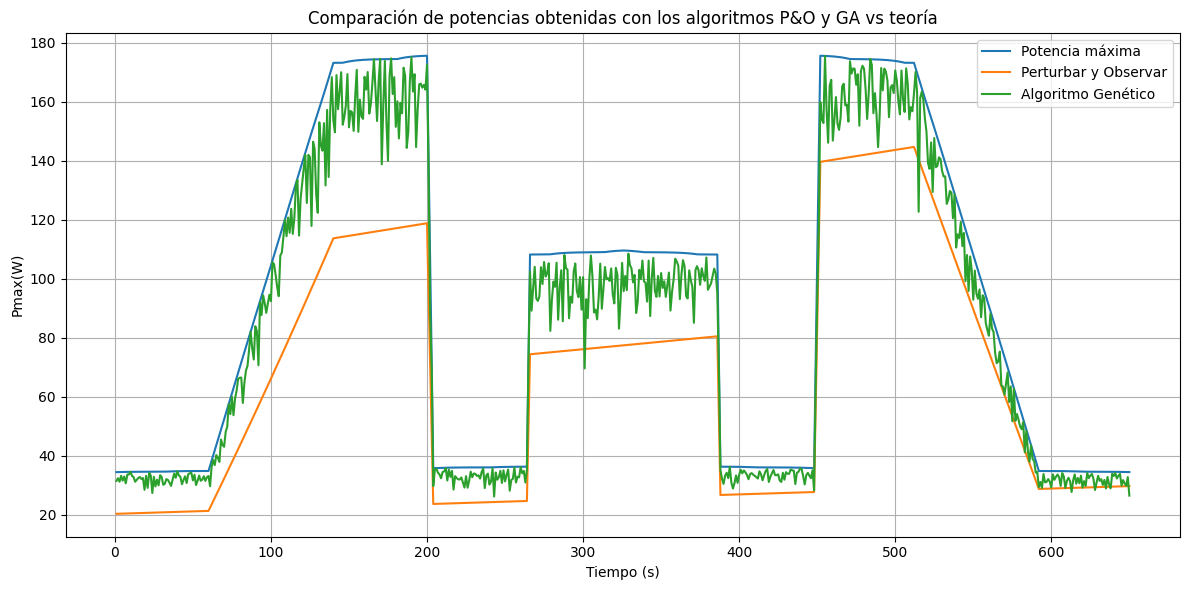

In [24]:
# Plot the obtained power per second and the maximum powe
plt.figure(figsize=(12, 6))
#plt.plot(df_results['Tiempo'], df_results['Eficiencia_IC'], label='Conductancia Incremental')
plt.plot(df_results['Tiempo'], df_results['Pmax'], label='Potencia máxima')
plt.plot(df_results['Tiempo'], df_results['P_PO'], label='Perturbar y Observar')
plt.plot(df_results['Tiempo'], df_results['P_GA'], label='Algoritmo Genético')
plt.xlabel('Tiempo (s)')
plt.ylabel('Pmax(W)')
plt.title('Comparación de potencias obtenidas con los algoritmos P&O y GA vs teoría')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### **Experiment 2: Classical Algorithm vs Artificial Intelligence**
- **Objective**: Compare the classical **P&O** algorithm with the **Artificial Neural Network (ANN)** approach (MLP Regressor).
- **Metrics**:
  - Accuracy in predicting $(V_{\text{MPP}})$.
  - Adaptability to dynamic irradiance and temperature changes.
  - Energy harvesting efficiency over time.

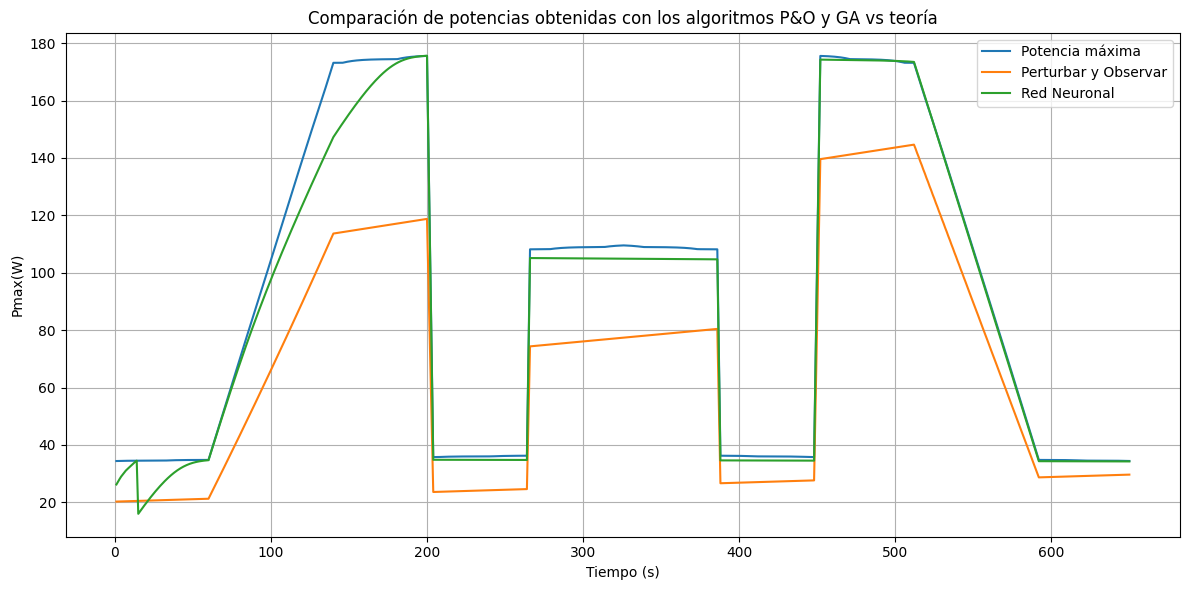

In [31]:
# Plot the obtained power per second and the maximum powe
plt.figure(figsize=(12, 6))
plt.plot(df_results['Tiempo'], df_results['Pmax'], label='Potencia máxima')
plt.plot(df_results['Tiempo'], df_results['P_PO'], label='Perturbar y Observar')
plt.plot(df_results['Tiempo'], df_results['P_NN'], label='Red Neuronal')
plt.xlabel('Tiempo (s)')
plt.ylabel('Pmax(W)')
plt.title('Comparación de potencias obtenidas con los algoritmos P&O y GA vs teoría')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

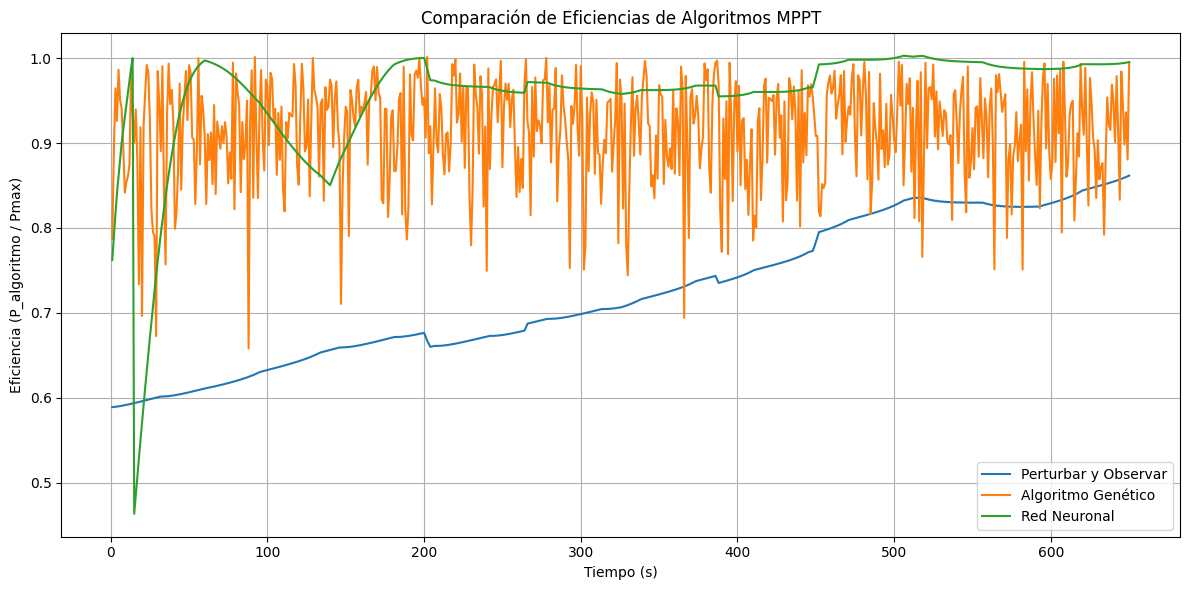

In [32]:
# Graficar las eficiencias
plt.figure(figsize=(12, 6))
#plt.plot(df_results['Tiempo'], df_results['Eficiencia_IC'], label='Conductancia Incremental')
plt.plot(df_results['Tiempo'], df_results['Eficiencia_PO'], label='Perturbar y Observar')
plt.plot(df_results['Tiempo'], df_results['Eficiencia_GA'], label='Algoritmo Genético')
plt.plot(df_results['Tiempo'], df_results['Eficiencia_NN'], label='Red Neuronal')
plt.xlabel('Tiempo (s)')
plt.ylabel('Eficiencia (P_algoritmo / Pmax)')
plt.title('Comparación de Eficiencias de Algoritmos MPPT')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### **Experiment 3: Variations in GA Initialization and Selection**
- **Objective**: Explore how different initialization methods and selection strategies affect the performance of the Genetic Algorithm.
- **Aspects to analyze**:
  - Initialization types: Random vs. Heuristic  (V-max-power).
  - Selection strategies: Tournament VS Rab, Roulette Wheel.
- **Outcome**: Determine the most effective configurations for GA under different conditions.


In [52]:
def genetic_algorithm_extended(time, V_min, V_max, population_size, generations, V_max_power):
    """
    Implements an extended version of the genetic algorithm with four different initialization and selection strategies.

    Parameters:
        time (float): Current time.
        V_min (float): Minimum possible voltage.
        V_max (float): Maximum possible voltage.
        population_size (int): Size of the population.
        generations (int): Number of generations.
        V_max_power (float): Voltage corresponding to the maximum power (used for heuristic initialization).

    Returns:
        V_best_1 (float): Best voltage from Random Initialization + Tournament Selection.
        V_best_2 (float): Best voltage from Random Initialization + Roulette Wheel Selection.
        V_best_3 (float): Best voltage from Heuristic Initialization + Roulette Wheel Selection.
        V_best_4 (float): Best voltage from Heuristic Initialization + Tournament Selection.
    """

    # Helper function for Random Initialization
    def random_init(V_min, V_max, population_size):
        return np.random.uniform(V_min, V_max, population_size)

    # Helper function for Heuristic Initialization
    def heuristic_init(V_max_power, V_min, V_max, population_size):
        # Initialize around V_max_power con una desviación estándar pequeña
        std_dev = (V_max - V_min) * 0.05  # 5% del rango de voltaje
        population = np.random.normal(loc=V_max_power, scale=std_dev, size=population_size)
        # Asegurar que los voltajes estén dentro de [V_min, V_max]
        population = np.clip(population, V_min, V_max)
        return population

    # Helper function for Tournament Selection
    def tournament_selection(population, fitness, k=2):
        selected = []
        for _ in range(len(population)):
            # Seleccionar aleatoriamente 'k' individuos para el torneo
            participants = np.random.choice(len(population), k, replace=False)
            # Seleccionar el individuo con la máxima aptitud
            winner = participants[np.argmax(fitness[participants])]
            selected.append(population[winner])
        return np.array(selected)

    # Helper function for Roulette Wheel Selection
    def roulette_wheel_selection(population, fitness):
        total_fitness = np.sum(fitness)
        if total_fitness <= 0:
            # Si todas las aptitudes son cero o negativas, seleccionar uniformemente
            probabilities = np.full(len(fitness), 1 / len(fitness))
        else:
            probabilities = fitness / total_fitness
        # Asegurarse de que las probabilidades sean no negativas y sumen 1
        probabilities = np.clip(probabilities, 0, None)
        probabilities_sum = np.sum(probabilities)
        if probabilities_sum == 0:
            # Evitar división por cero, asignar probabilidades uniformes
            probabilities = np.full(len(fitness), 1 / len(fitness))
        else:
            probabilities /= probabilities_sum
        selected_indices = np.random.choice(len(population), size=len(population), p=probabilities)
        return population[selected_indices]

    # Generic GA runner
    def run_ga(initialization, selection_method):
        # Inicializar población
        population = initialization(V_min, V_max, population_size)

        for _ in range(generations):
            # Evaluar fitness
            fitness = []
            for V in population:
                # Calcular corriente usando el modelo de diodo único
                I = current_single_diode(V, time, I_sc_ref, alpha_Isc, V_oc_ref, n,
                                        T_ref, G_ref, E_g, R_s, R_sh, k, q)
                # Calcular potencia como V * I, asegurando que sea no negativa
                if not np.isnan(I):
                    P = V * I
                    P = max(P, 0)  # Asegurar que P no sea negativo
                else:
                    P = 0
                fitness.append(P)
            fitness = np.array(fitness)

            # Selección
            selected_population = selection_method(population, fitness)

            # Crossover y Mutación
            children = []
            while len(children) < population_size:
                # Seleccionar dos padres aleatoriamente
                parents = np.random.choice(selected_population, 2)
                # Crear un hijo promediando los padres (crossover simple)
                child = np.mean(parents)
                # Aplicar mutación con una pequeña probabilidad
                mutation_prob = 0.01
                if np.random.rand() < mutation_prob:
                    child += np.random.normal(0, (V_max - V_min) * 0.01)
                # Asegurar que el hijo esté dentro de los límites de voltaje
                child = np.clip(child, V_min, V_max)
                children.append(child)
            population = np.array(children)

        # Evaluación final de fitness
        fitness = []
        for V in population:
            I = current_single_diode(V, time, I_sc_ref, alpha_Isc, V_oc_ref, n,
                                    T_ref, G_ref, E_g, R_s, R_sh, k, q)
            if not np.isnan(I):
                P = V * I
                P = max(P, 0)  # Asegurar que P no sea negativo
            else:
                P = 0
            fitness.append(P)
        fitness = np.array(fitness)

        # Identificar el mejor individuo
        best_index = np.argmax(fitness)
        V_best = population[best_index]
        return V_best

    # Variante 1: Inicialización Aleatoria + Selección por Torneo
    V_best_1 = run_ga(random_init, tournament_selection)

    # Variante 2: Inicialización Aleatoria + Selección por Ruleta
    V_best_2 = run_ga(random_init, roulette_wheel_selection)

    # Variante 3: Inicialización Heurística + Selección por Ruleta
    V_best_3 = run_ga(lambda V_min, V_max, pop_size: heuristic_init(V_max_power, V_min, V_max, pop_size),
                     roulette_wheel_selection)

    # Variante 4: Inicialización Heurística + Selección por Torneo
    V_best_4 = run_ga(lambda V_min, V_max, pop_size: heuristic_init(V_max_power, V_min, V_max, pop_size),
                     tournament_selection)

    return V_best_1, V_best_2, V_best_3, V_best_4


In [56]:
# Parámetros adicionales para los algoritmos
population_size = 10  # Tamaño de la población para el algoritmo genético
generations = 5       # Número de generaciones para el algoritmo genético
V_min = 12
V_max = V_oc_ref * 1.2

time_steps = np.arange(time_start, time_end + 1, 1)

# Variables para almacenar los resultados
results = {
    'Tiempo': [],
    'Pmax': [],
    'P_GA_1': [],
    'P_GA_2': [],
    'P_GA_3': [],
    'P_GA_4': [],
    'P_NN': [],  # Asegurarse de inicializar esta clave
    'Eficiencia_GA_1': [],
    'Eficiencia_GA_2': [],
    'Eficiencia_GA_3': [],
    'Eficiencia_GA_4': []
}

# Bucle principal
for current_time in tqdm(time_steps, desc="Processing times"):
    # Actualizar V_max si V_oc cambia con el tiempo
    V_max_current = V_max  # Ajusta esto si V_oc varía con el tiempo

    # Calcular el Pmax real
    V_values = np.linspace(V_min, V_max_current, 100)
    P_values = []
    for V in V_values:
        I = current_single_diode(V, current_time, I_sc_ref, alpha_Isc, V_oc_ref, n,
                                T_ref, G_ref, E_g, R_s, R_sh, k, q)
        P = V * I if not np.isnan(I) else 0
        P = max(P, 0)  # Asegurar que P no sea negativo
        P_values.append(P)
    P_values = np.array(P_values)
    idx_max = np.argmax(P_values)
    P_max = P_values[idx_max]
    V_max_power = V_values[idx_max]

    # Ejecutar el Algoritmo Genético Extendido
    V_best_1, V_best_2, V_best_3, V_best_4 = genetic_algorithm_extended(
        current_time, V_min, V_max_current, population_size, generations, V_max_power
    )

    # Calcular las potencias correspondientes para cada variante
    def calculate_power(V_best):
        I = current_single_diode(V_best, current_time, I_sc_ref, alpha_Isc, V_oc_ref, n,
                                T_ref, G_ref, E_g, R_s, R_sh, k, q)
        if not np.isnan(I):
            P = V_best * I
            P = max(P, 0)  # Asegurar que P no sea negativo
        else:
            P = 0
        return P

    P_GA_1 = calculate_power(V_best_1)
    P_GA_2 = calculate_power(V_best_2)
    P_GA_3 = calculate_power(V_best_3)
    P_GA_4 = calculate_power(V_best_4)

    # Calcular P_NN si corresponde (asegúrate de que P_NN esté definido)
    # Por ejemplo:
    # P_NN = neural_network_prediction(current_time)
    # Aquí, necesitarías definir cómo obtienes P_NN.

    # Supongamos que tienes una función para calcular P_NN:
    P_NN = 0  # Reemplaza esto con tu lógica real

    # Almacenar los resultados
    results['Tiempo'].append(current_time)
    results['Pmax'].append(P_max)
    results['P_GA_1'].append(P_GA_1)
    results['P_GA_2'].append(P_GA_2)
    results['P_GA_3'].append(P_GA_3)
    results['P_GA_4'].append(P_GA_4)
    results['P_NN'].append(P_NN)
    results['Eficiencia_GA_1'].append(P_GA_1 / P_max if P_max != 0 else 0)
    results['Eficiencia_GA_2'].append(P_GA_2 / P_max if P_max != 0 else 0)
    results['Eficiencia_GA_3'].append(P_GA_3 / P_max if P_max != 0 else 0)
    results['Eficiencia_GA_4'].append(P_GA_4 / P_max if P_max != 0 else 0)

# Crear un DataFrame con los resultados
import pandas as pd
df_results_GA = pd.DataFrame(results)

# Mostrar las primeras filas de los resultados
print(df_results_GA.head())


Processing times: 100%|██████████| 650/650 [01:19<00:00,  8.14it/s]

   Tiempo       Pmax     P_GA_1     P_GA_2     P_GA_3     P_GA_4  P_NN  \
0       1  34.387348  32.809828  27.711982  33.031266  34.360610     0   
1       2  34.404836  33.414049  27.311542  33.992013  34.018859     0   
2       3  34.420259  31.200840  27.419519  34.100971  34.341564     0   
3       4  34.433856  34.430216  28.942229  34.329028  34.420422     0   
4       5  34.445838  26.640049  31.334448  33.926658  34.083788     0   

   Eficiencia_GA_1  Eficiencia_GA_2  Eficiencia_GA_3  Eficiencia_GA_4  
0         0.954125         0.805877         0.960565         0.999222  
1         0.971202         0.793829         0.988001         0.988781  
2         0.906467         0.796610         0.990724         0.997714  
3         0.999894         0.840517         0.996956         0.999610  
4         0.773390         0.909673         0.984928         0.989489  


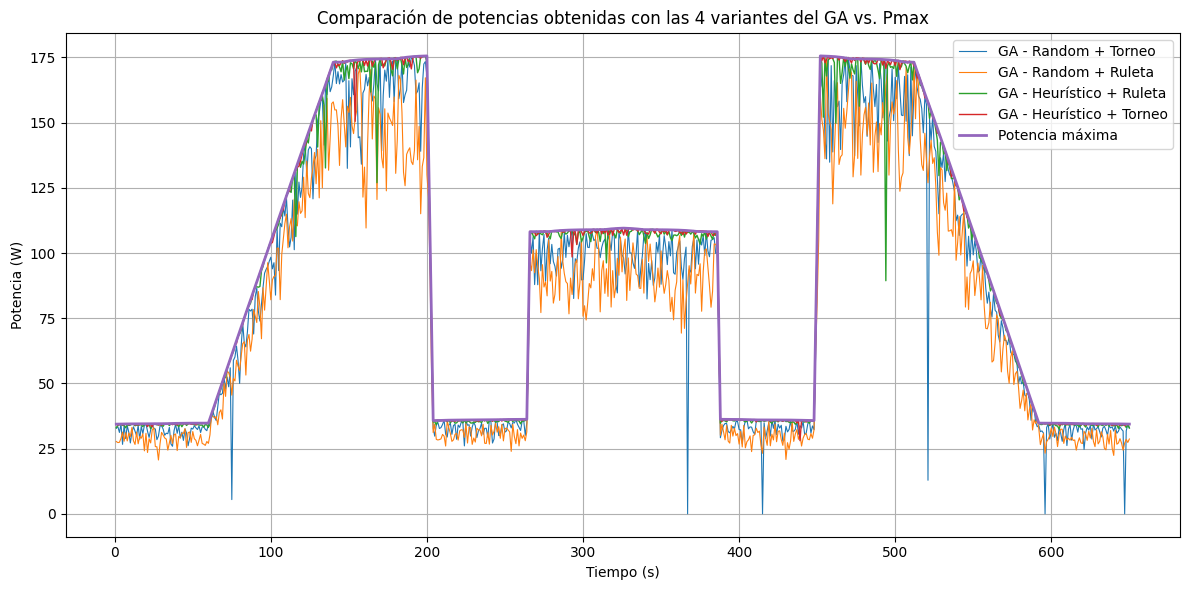

In [62]:
plt.figure(figsize=(12, 6))
plt.plot(df_results_GA['Tiempo'], df_results_GA['P_GA_1'], label='GA - Random + Torneo', linewidth=0.8)
plt.plot(df_results_GA['Tiempo'], df_results_GA['P_GA_2'], label='GA - Random + Ruleta', linewidth=0.8)
plt.plot(df_results_GA['Tiempo'], df_results_GA['P_GA_3'], label='GA - Heurístico + Ruleta', linewidth=1)
plt.plot(df_results_GA['Tiempo'], df_results_GA['P_GA_4'], label='GA - Heurístico + Torneo', linewidth=1)
plt.plot(df_results_GA['Tiempo'], df_results_GA['Pmax'], label='Potencia máxima', linewidth=2)
plt.xlabel('Tiempo (s)')
plt.ylabel('Potencia (W)')
plt.title('Comparación de potencias obtenidas con las 4 variantes del GA vs. Pmax')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### **Experiment 4: Implementation of a Different Radiation Profile**
- **Objective**: Test the algorithms' adaptability and efficiency using a new irradiance profile.
- **Approach**:
  - Define a new time-based irradiance profile with dynamic variations.
  - Evaluate the algorithms' ability to track the MPP under these conditions.


In [66]:
def irradiance_profile(time):
    # Determine the segment index (each segment is 5 seconds long)
    segment = int(time // 5)
    local_time = time % 5  # Time within the current segment

    # Alternating pattern of increasing and decreasing irradiance
    if segment % 2 == 0:  # Even segments (increasing)
        return 200 + 200 * local_time
    else:  # Odd segments (decreasing)
        return 1200 - 200

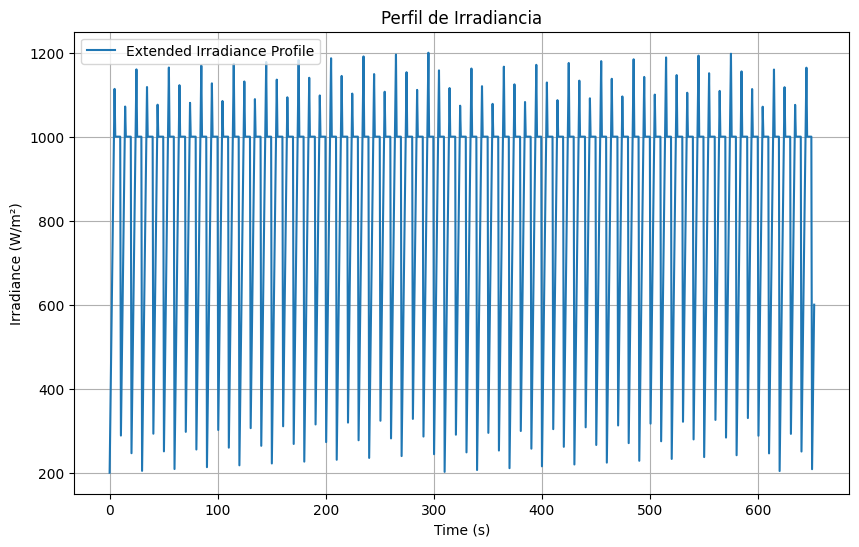

In [67]:
time_extended = np.linspace(0, 652, 1000)
irradiance_extended = [irradiance_profile(t) for t in time_extended]

# Plot the extended irradiance profile
plt.figure(figsize=(10, 6))
plt.plot(time_extended, irradiance_extended, label="Extended Irradiance Profile")
plt.title("Perfil de Irradiancia")
plt.xlabel("Time (s)")
plt.ylabel("Irradiance (W/m²)")
plt.grid()
plt.legend()
plt.show()

In [82]:
# Additional parameters for the algorithms
delta_V = 0.01  # Voltage step for P&O and IC
population_size = 10  # Population size for the genetic algorithm
generations = 5       # Number of generations for the genetic algorithm
V_min = 12
V_max = V_oc_ref * 1.2

# Train the neural network before the main loop
time_steps = np.arange(time_start, time_end + 0.1)
model_nn = train_neural_network(time_steps, V_oc_ref)

# Variables to store the results
results = {
    'Tiempo': [],
    'Pmax': [],
    'P_IC': [],
    'P_PO': [],
    'P_GA': [],
    'P_NN': [],
    'Eficiencia_IC': [],
    'Eficiencia_PO': [],
    'Eficiencia_GA': [],
    'Eficiencia_NN': []
}

# Initialize variables for P&O and IC
V_prev_IC = V_min
V_prev_PO = V_min
I_prev_IC = current_single_diode(V_prev_IC, time_start, I_sc_ref, alpha_Isc, V_oc_ref, n, T_ref, G_ref, E_g, R_s, R_sh, k, q)
I_prev_PO = current_single_diode(V_prev_PO, time_start, I_sc_ref, alpha_Isc, V_oc_ref, n, T_ref, G_ref, E_g, R_s, R_sh, k, q)
P_prev_PO = V_prev_PO * I_prev_PO
direction_PO = 1  # Initial direction for P&O

# Main loop
for current_time in tqdm(time_steps, desc="Processing times"):
    # Update V_max if V_oc changes with time
    V_max_current = V_max  # Adjust this if V_oc varies with time

    # Calculate the real Pmax
    V_values = np.linspace(V_min, V_max_current, 100)
    P_values = []
    for V in V_values:
        I = current_single_diode(V, current_time, I_sc_ref, alpha_Isc, V_oc_ref, n, T_ref, G_ref, E_g, R_s, R_sh, k, q)
        P = V * I if not np.isnan(I) else 0
        P_values.append(P)
    P_values = np.array(P_values)
    idx_max = np.argmax(P_values)
    P_max = P_values[idx_max]
    V_max_power = V_values[idx_max]

    # Incremental Conductance
    I_current_IC = current_single_diode(V_prev_IC, current_time, I_sc_ref, alpha_Isc, V_oc_ref, n, T_ref, G_ref, E_g, R_s, R_sh, k, q)
    dV_IC = delta_V
    dI_IC = I_current_IC - I_prev_IC
    V_next_IC = incremental_conductance(V_prev_IC, I_current_IC, dV_IC, dI_IC)
    I_prev_IC = I_current_IC
    V_prev_IC = V_next_IC
    P_IC = V_next_IC * I_current_IC

    # Perturb and Observe
    V_next_PO, direction_PO = perturb_and_observe(V_prev_PO, P_prev_PO, delta_V, direction_PO)
    I_current_PO = current_single_diode(V_next_PO, current_time, I_sc_ref, alpha_Isc, V_oc_ref, n, T_ref, G_ref, E_g, R_s, R_sh, k, q)
    P_current_PO = V_next_PO * I_current_PO
    if P_current_PO > P_prev_PO:
        # Continue in the same direction
        pass
    else:
        # Change direction
        direction_PO *= -1
    V_prev_PO = V_next_PO
    P_prev_PO = P_current_PO
    P_PO = P_current_PO

    # Genetic Algorithm
    V_GA = genetic_algorithm(current_time, V_min, V_max_current, population_size, generations)
    I_GA = current_single_diode(V_GA, current_time, I_sc_ref, alpha_Isc, V_oc_ref, n, T_ref, G_ref, E_g, R_s, R_sh, k, q)
    P_GA = V_GA * I_GA if not np.isnan(I_GA) else 0

    # Neural Network
    V_NN = model_nn.predict([[current_time]])[0]
    I_NN = current_single_diode(V_NN, current_time, I_sc_ref, alpha_Isc, V_oc_ref, n, T_ref, G_ref, E_g, R_s, R_sh, k, q)
    P_NN = V_NN * I_NN if not np.isnan(I_NN) else 0

    # Store results
    results['Tiempo'].append(current_time)
    results['Pmax'].append(P_max)
    results['P_IC'].append(P_IC)
    results['P_PO'].append(P_PO)
    results['P_GA'].append(P_GA)
    results['P_NN'].append(P_NN)
    results['Eficiencia_IC'].append(P_IC / P_max if P_max != 0 else 0)
    results['Eficiencia_PO'].append(P_PO / P_max if P_max != 0 else 0)
    results['Eficiencia_GA'].append(P_GA / P_max if P_max != 0 else 0)
    results['Eficiencia_NN'].append(P_NN / P_max if P_max != 0 else 0)

# Create a DataFrame with the results
df_results = pd.DataFrame(results)

# Display the first few results
print(df_results.head())

Processing times: 100%|██████████| 650/650 [00:41<00:00, 15.79it/s]

   Tiempo        Pmax        P_IC        P_PO        P_GA        P_NN  \
0     1.0   68.697141   40.649932   40.649812   65.457577   48.487123   
1     2.0  102.427086   61.097882   61.097762   79.752430   78.506212   
2     3.0  135.493356   81.579947   81.579827  100.665527  112.210148   
3     4.0  168.185001  102.096126  102.096006  162.887729  148.004508   
4     5.0  168.188191  102.181173  102.181053  161.298699  151.093785   

   Eficiencia_IC  Eficiencia_PO  Eficiencia_GA  Eficiencia_NN  
0       0.591727       0.591725       0.952843       0.705810  
1       0.596501       0.596500       0.778626       0.766459  
2       0.602096       0.602095       0.742955       0.828160  
3       0.607047       0.607046       0.968503       0.880010  
4       0.607541       0.607540       0.959037       0.898361  


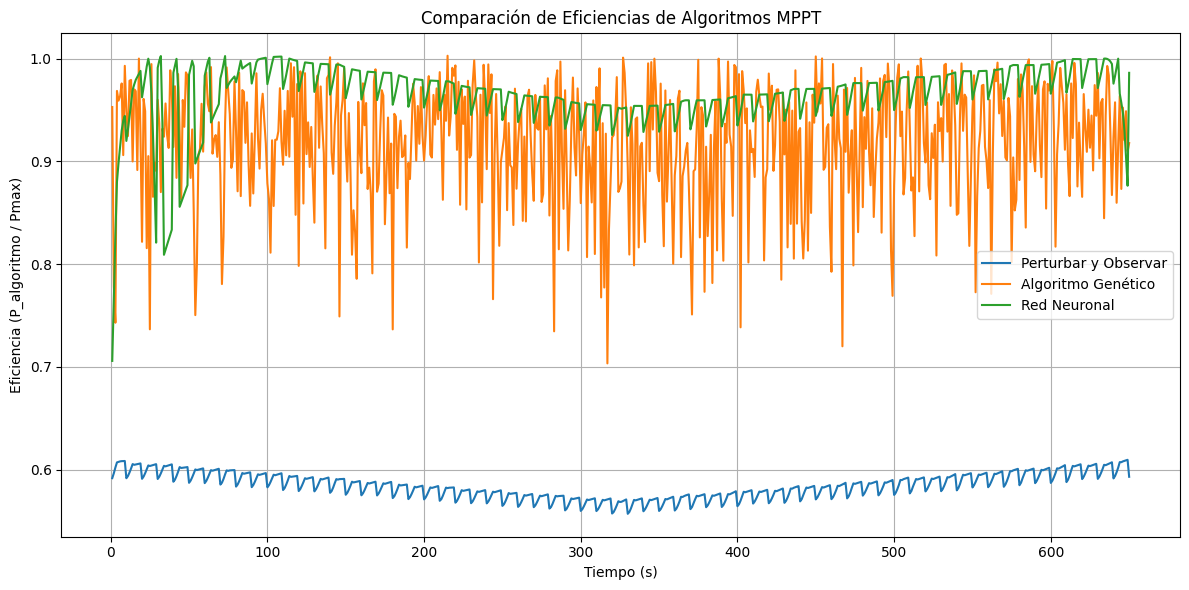

In [83]:
# Graficar las eficiencias
plt.figure(figsize=(12, 6))
plt.plot(df_results['Tiempo'], df_results['Eficiencia_PO'], label='Perturbar y Observar')
plt.plot(df_results['Tiempo'], df_results['Eficiencia_GA'], label='Algoritmo Genético')
plt.plot(df_results['Tiempo'], df_results['Eficiencia_NN'], label='Red Neuronal')
plt.xlabel('Tiempo (s)')
plt.ylabel('Eficiencia (P_algoritmo / Pmax)')
plt.title('Comparación de Eficiencias de Algoritmos MPPT')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

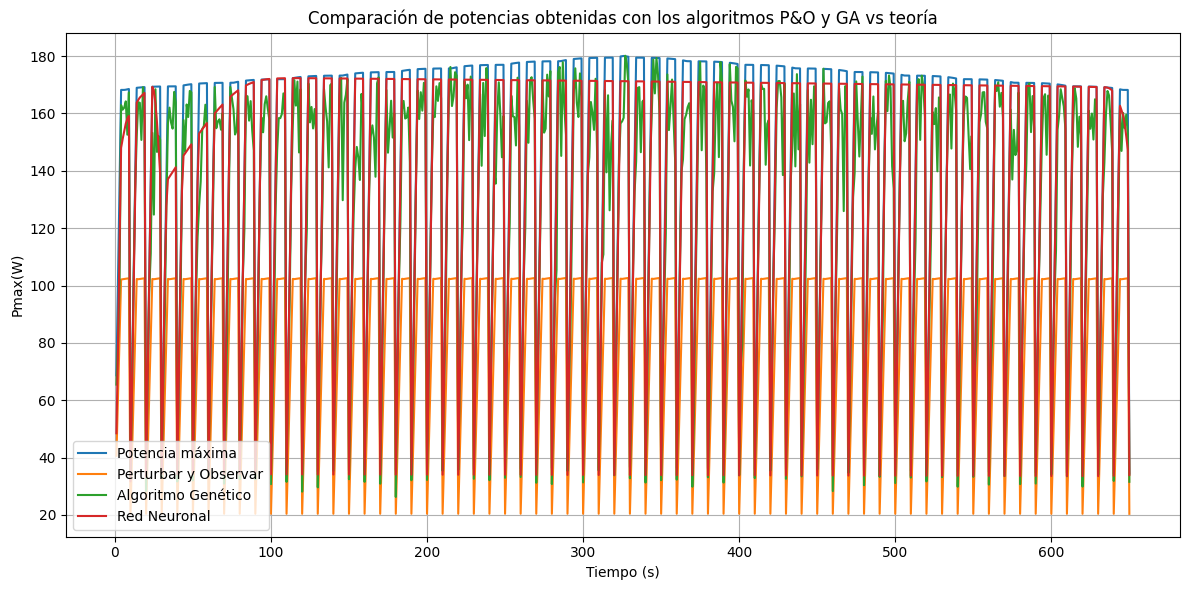

In [84]:
# Plot the obtained power per second and the maximum powe
plt.figure(figsize=(12, 6))
#plt.plot(df_results['Tiempo'], df_results['Eficiencia_IC'], label='Conductancia Incremental')
plt.plot(df_results['Tiempo'], df_results['Pmax'], label='Potencia máxima')
plt.plot(df_results['Tiempo'], df_results['P_PO'], label='Perturbar y Observar')
plt.plot(df_results['Tiempo'], df_results['P_GA'], label='Algoritmo Genético')
plt.plot(df_results['Tiempo'], df_results['P_NN'], label='Red Neuronal')
plt.xlabel('Tiempo (s)')
plt.ylabel('Pmax(W)')
plt.title('Comparación de potencias obtenidas con los algoritmos P&O y GA vs teoría')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()